In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime 
plt.style.use('seaborn')

In [2]:
df = pd.read_excel('Data.xlsx') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16572 entries, 0 to 16571
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                16572 non-null  int64 
 1   Name                      16572 non-null  object
 2   Position                  16572 non-null  object
 3   Age                       16572 non-null  object
 4   Nation                    16572 non-null  object
 5   Height                    16572 non-null  object
 6   Main leg                  16572 non-null  object
 7   Start contract date       16572 non-null  object
 8   Expiration contract date  16572 non-null  object
 9   Cost                      16572 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.3+ MB


In [3]:
df.isin(['-']).sum()

Unnamed: 0                     0
Name                           0
Position                       0
Age                           29
Nation                         0
Height                         0
Main leg                       0
Start contract date          544
Expiration contract date    2714
Cost                         760
dtype: int64

In [4]:
df

,Unnamed: 0,Name,Position,Age,Nation,Height,Main leg,Start contract date,Expiration contract date,Cost
0,0,Ederson,Вратарь,28,"['Бразилия', 'Португалия']","1,88 m",L,01 июля 2017 г.,30 июня 2026 г.,"50,00 млн €"
1,1,Zack Steffen,Вратарь,27,['Соединенные Штаты Америки'],"1,91 m",R,09 июля 2019 г.,30 июня 2025 г.,"6,00 млн €"
2,2,Scott Carson,Вратарь,36,['Англия'],"1,88 m",R,20 июля 2021 г.,30 июня 2022 г.,300 тыс €
3,3,Rúben Dias,Центр. защитник,25,['Португалия'],"1,87 m",R,29 сент. 2020 г.,30 июня 2027 г.,"75,00 млн €"
4,4,Aymeric Laporte,Центр. защитник,27,"['Испания', 'Франция']","1,89 m",L,30 янв. 2018 г.,30 июня 2025 г.,"45,00 млн €"
...,...,...,...,...,...,...,...,...,...,...
16567,16567,Emmett McGuckin,Центральный нап.,31,['Северная Ирландия'],"1,83 m",R,01 июля 2021 г.,-,50 тыс €
16568,16568,Alex Gawne,Центральный нап.,20,['Северная Ирландия'],"1,71 m",R,04 июля 2021 г.,31 мая 2022 г.,50 тыс €
16569,16569,Jordan Gibson,Центральный нап.,26,['Северная Ирландия'],m,R,11 сент. 2020 г.,30 июня 2022 г.,50 тыс €
16570,16570,Jonathan Doyle,Центральный нап.,19,['Северная Ирландия'],m,R,01 июля 2021 г.,30 июня 2022 г.,10 тыс €


<h1>Обработка и приведение данных</h1>

<h2>2.Приведение данных</h2>

<b>Пустые значения в таблице во время парсинга были заменены на дефисы, поэтому удаление наблюдений будет происходить по поиску дефисов в ячейках</b>

In [5]:
# Удаление дупликатов и наблюдений с пустыми значениями
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop_duplicates('Name', inplace=True)
df = df[~(df['Expiration contract date'] == '-')]
df = df[~ (df['Start contract date'] == '-')]
df = df[~ df['Cost'].isin(['-'])]
df = df[~ (df['Height'] == ' m')]

df.rename({'Main leg': 'Main_leg', 'Start contract date': 'Start_contract_date', 'Expiration contract date': 'Expiration_contract_date'}, 
          axis=1, inplace=True) # переименуем столбцы для дальнейшего удобства и возможности использования при построении множественной регресии

In [6]:
def to_date_format(date_str): 
    # чтоб привести в формат времени, создадим функцию, которая заменит сокращения месяцев на русском языке на названия месяцев в английском языке, 
    # и приведет в формат "dd mm, yyyy"
    months = {
        'янв.': 'January',
        'февр.': 'February',
        'марта': 'March',
        'апр.': 'April',
        'мая': 'May',
        'июня': 'June',
        'июля': 'July',
        'авг.': 'August',
        'сент.': 'September',
        'окт.': 'October',
        'нояб.': 'November',
        'дек.': 'December'
    }
    
    date = date_str.split()
    return f'{date[0]} {months[date[1]]}, {date[2]}'

pattern = re.compile(r'\d+')
df['Height'] = df['Height'].apply(lambda x: int(''.join(re.findall(pattern=pattern, string=x))))
df = df[df['Height'] > 19]
df['Start_contract_date'] = pd.to_datetime(df['Start_contract_date'].apply(to_date_format))
df['Expiration_contract_date'] = pd.to_datetime(df['Expiration_contract_date'].apply(to_date_format))
df['Contract_duration_days'] = (df['Expiration_contract_date'] - df['Start_contract_date']).dt.days
df['Contract_remaining_days'] = (df['Expiration_contract_date'] - datetime.datetime.fromisoformat('2022-03-01')).dt.days
df['Age'] = df['Age'].astype(int)


# преобразуем текстовый формат в числовой с помощью регулярных выражений
def get_cost(num):
    change = {'тыс €': 1000, 'млн €': 1_000_000}
    pattern = re.compile(r'(\d{1,}),?\d{,2} (.+)')
    cost_match = re.match(pattern=pattern, string=num)
    cost = int(cost_match.group(1))
    nominal = cost_match.group(2)
    cost *= change[nominal]
    return cost

df['Cost'] = df['Cost'].apply(get_cost)

<h2>3. Создание новых признаков</h2>

In [7]:
# создадим бинарный столбец, показывающий, является ли игрок правшой
df['Right'] = df['Main_leg'].apply(lambda x: 1 if x == 'R' else 0)


df['Amount_of_citizenships'] = df['Nation']\
        .apply(lambda x: len(x.strip('[').strip(']').split(', ')) if  x.strip('[').strip(']') not in 
        ('Северная Ирландия', 'Соединенные Штаты Америки', 'Южная Африка', 'ДР Конго', 
         'Босния и Герцеговина', 'Тринидад и Тобаго') else 1)

# создадим бинарный столбец, отаражающий, есть ли у игрока двойное гражданство 
df['Two_citizenships'] = (df['Nation']\
        .apply(lambda x: len(x.strip('[').strip(']').split(', ')) if  x.strip('[').strip(']') not in 
        ('Северная Ирландия', 'Соединенные Штаты Америки', 'Южная Африка', 'ДР Конго', 
         'Босния и Герцеговина', 'Тринидад и Тобаго') else 1) - 1)

df['Main_nation'] = df['Nation'].apply(lambda x: x.strip('[').strip(']').split(', ')[0].strip("'"))

# Создадим категориальный признак, отражающий позицию игрока
# 0 - защита 
# 1 - полузащита
# 2 - нападение
def split_to_categories(position):
    if re.match(r'.+\sзащитник', position) or position in ('Защита', 'Вратарь'):
        return 0
    elif re.match(r'.+\sполузащитник', position) or position == 'Полузащита':
        return 1
    else:
        return 2
    
df['Position_cat'] = df['Position'].apply(split_to_categories) 

<h3>Чистка от выбросов по столбцу стоимости</h3>

In [8]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 9))

# df[['Cost']].boxplot(ax=ax[0])

# q1 = df['Cost'].quantile(0.25)
# q3 = df['Cost'].quantile(0.75)
# iqr = q3 -q1 

# df = df[(df['Cost'] > q1 - 1.5*iqr) & (df['Cost'] < q3 + 1.5*iqr)]

# df[['Cost']].boxplot(ax=ax[1])

Этап с чисткой выбросов было принято пропустить, так как после чистки остаются только недорогостоящие футболисты, модель теряет смысл.

<h1>4. Разведывательный анализ</h1>

<AxesSubplot:>

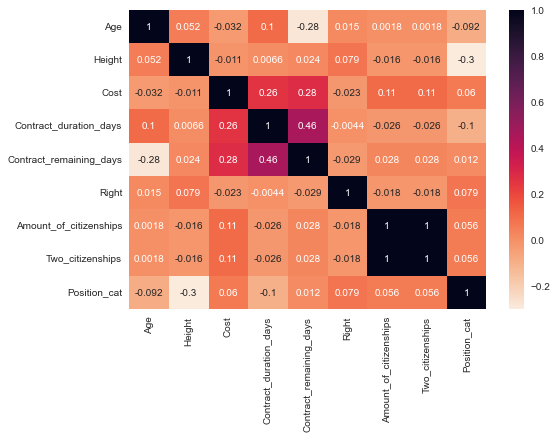

In [9]:
corr = df.corr()
sns.heatmap(corr, cmap='rocket_r', annot=True)

In [10]:
corr.nlargest(9, 'Cost')['Cost']

Cost                       1.000000
Contract_remaining_days    0.275348
Contract_duration_days     0.257813
Two_citizenships           0.105029
Amount_of_citizenships     0.105029
Position_cat               0.060162
Height                    -0.011141
Right                     -0.023181
Age                       -0.032426
Name: Cost, dtype: float64

<h4>На основе данной корреляционной матрицы можно сделать такие выводы:</h4>
<li>Чем ближе дата окончания контракта, тем ниже стоимость игрока 0.275</li>
<li>Чем больше продолжительность контракта, тем выше стоимость игрока 0.257</li>
<li>Чем ближе дата окончания контракта, тем старше игрок -0.28</li>
<li>Чем ближе игрок к нападающей позиции, тем ниже его рост -0.3</li>

In [11]:
df.describe()

,Age,Height,Cost,Contract_duration_days,Contract_remaining_days,Right,Amount_of_citizenships,Two_citizenships,Position_cat
count,12312.000000,12312.000000,1.231200e+04,12312.000000,12312.000000,12312.000000,12312.00000,12312.00000,12312.000000
mean,26.008122,182.506741,2.752355e+06,1209.205897,548.330491,0.773148,1.23335,0.23335,0.824399
std,4.602581,6.739628,8.050616e+06,855.124300,420.564972,0.418813,0.42298,0.42298,0.817541
min,16.000000,160.000000,1.000000e+04,-1.000000,-244.000000,0.000000,1.00000,0.00000,0.000000
25%,22.000000,178.000000,2.000000e+05,654.000000,121.000000,1.000000,1.00000,0.00000,0.000000
50%,26.000000,183.000000,4.000000e+05,1080.000000,486.000000,1.000000,1.00000,0.00000,1.000000
75%,29.000000,187.000000,1.000000e+06,1623.000000,852.000000,1.000000,1.00000,0.00000,2.000000
max,46.000000,205.000000,1.600000e+08,7851.000000,3408.000000,1.000000,2.00000,1.00000,2.000000


In [12]:
df.groupby('Main_leg')['Age', 'Height', 'Cost'].agg(['mean', 'median'])

<ipython-input-12-da13b045d9a0>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('Main_leg')['Age', 'Height', 'Cost'].agg(['mean', 'median'])


Age             Height                 Cost          
               mean median        mean median          mean    median
Main_leg                                                             
L         25.884354   25.0  181.526674  182.0  3.096862e+06  500000.0
R         26.044437   26.0  182.794306  183.0  2.651273e+06  400000.0

<ul>
    <li>Средний возраст правоногих и левоногих футболистов совпадает</li>
    <li>Также совпадает средний рост правоногих и левоногих футболистов</li> 
    <li>Cредняя цена левоногих футболистов на трансферном рынке больше, чем у правоногих (одна из причин, их количество)</li></ul>

In [13]:
df.groupby('Position_cat')['Amount_of_citizenships'].value_counts()

Position_cat  Amount_of_citizenships
0             1                         4235
              2                         1150
1             1                         2865
              2                          839
2             1                         2339
              2                          884
Name: Amount_of_citizenships, dtype: int64

<li>Как мы можем увидеть, больше всего тех футболистов, кто играет в защите и имеет одно гражданство, также их число почти в 1.5 раза превышает тех, кто играет в нападении и имеет одно гражданство.</li>
<li>Равные доли составляют игроки с двумя гражданствами и играющие в полузащите и в нападении.</li>

In [14]:
df.groupby('Position_cat')['Age', 'Height', 'Cost'].agg(['mean', 'median'])

<ipython-input-14-0978dc3b6016>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('Position_cat')['Age', 'Height', 'Cost'].agg(['mean', 'median'])


Age             Height                 Cost          
                   mean median        mean median          mean    median
Position_cat                                                             
0             26.517363   26.0  185.352646  186.0  2.232284e+06  400000.0
1             25.675486   25.0  179.738391  180.0  2.948458e+06  450000.0
2             25.539559   25.0  180.933292  181.0  3.395923e+06  500000.0

<li>Средний возраст по всем позиция - 25-27 лет</li>
<li>Самые высокие игроки - защитники</li>
<li>Средняя стоимость по категориям(защита, полузащита, нападение) выше всего у атакующих</li>

<h1>5. Визуализация и гипотезы</h1>

<h4>H0-H1: Рост и возраст игроков распределены нормально</h4>

Text(0, 0.5, 'Частота')

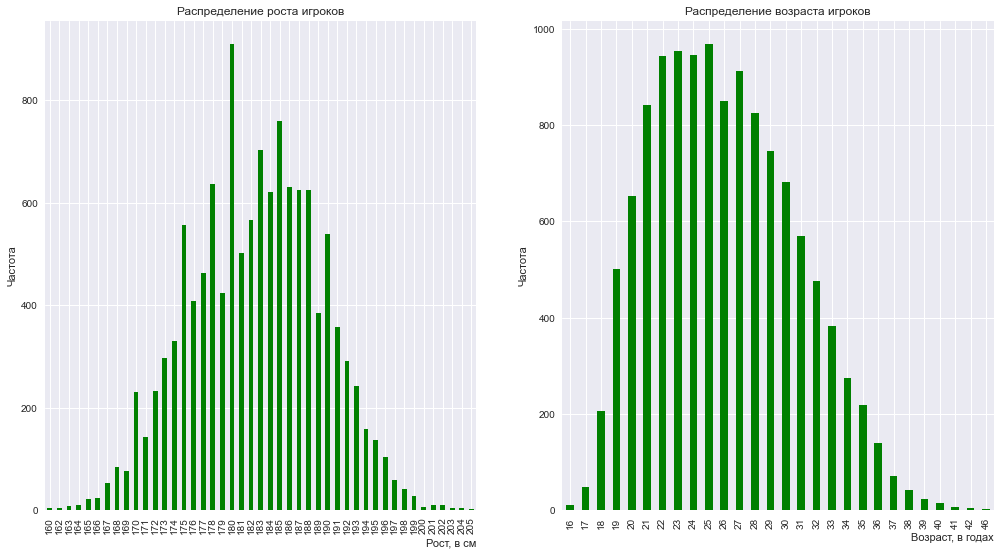

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(17, 9))
df.groupby('Height').size().plot(kind='bar', ax=ax[0], color='green')
ax[0].set_title('Распределение роста игроков')
ax[0].set_xlabel('Рост, в см', loc='right')
ax[0].set_ylabel('Частота')

df.groupby('Age').size().plot(kind='bar', ax=ax[1], color='green')
ax[1].set_title('Распределение возраста игроков')
ax[1].set_xlabel('Возраст, в годах', loc='right')
ax[1].set_ylabel('Частота')

<ul>H0-H1 не отвергнуты:
    <li>Рост футболистов имеет нормальное распреление.</li>
    <li>Распределение возраста футболистов тоже распределено нормально, однако имеет сдвиг в сторону более молодых игроков.</li>
</ul>

<h4>H2: Атакующие в среднем стоят намного больше остальных</h4>

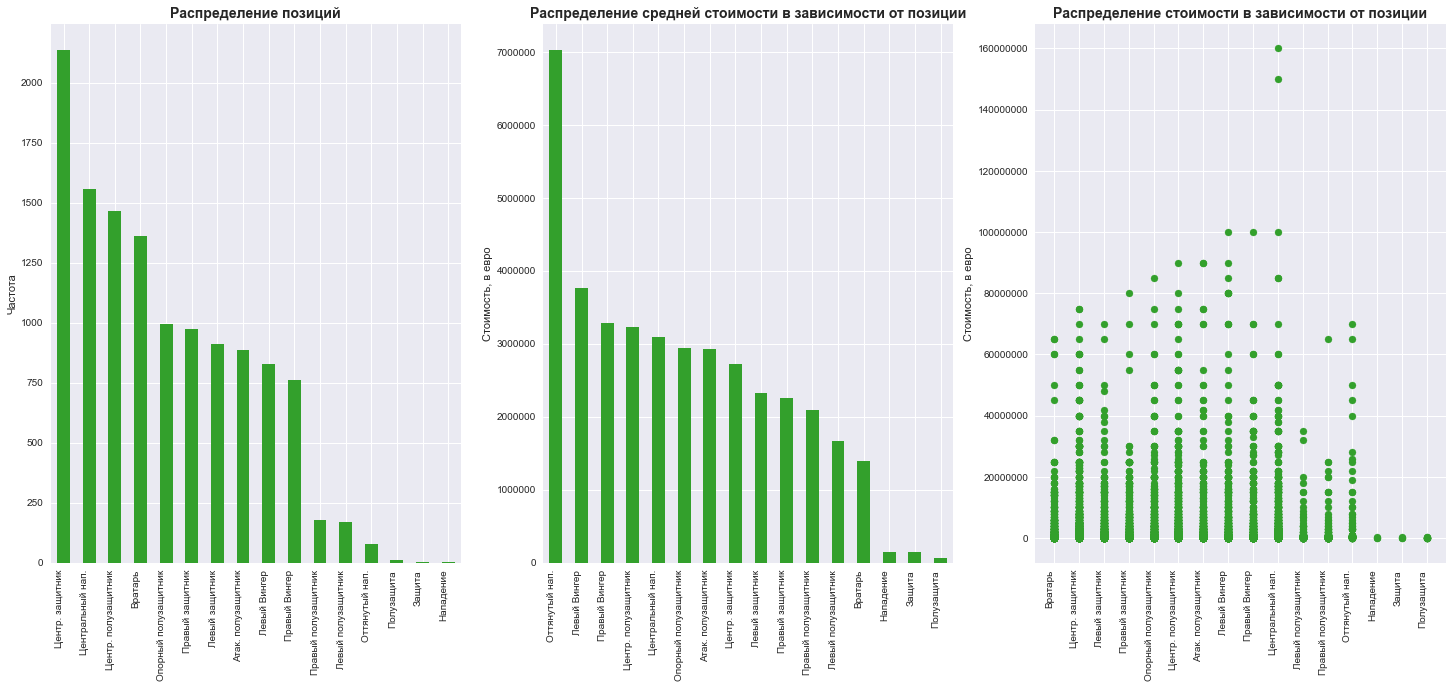

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(25, 11))
positions = df.groupby('Position').size().sort_values(ascending=False)
positions.plot(kind='bar', ax=ax[0], color=sns.color_palette("Paired")[3])
ax[0].set_title('Распределение позиций', fontdict={'size': 14, 'weight': 'bold'})
ax[0].set_xlabel('', visible=False)
ax[0].set_ylabel('Частота')


positions_cost = df.groupby('Position')['Cost'].mean().sort_values(ascending=False)
positions_cost.plot(kind='bar', ax=ax[1], color=sns.color_palette("Paired")[3])
ax[1].set_title('Распределение средней стоимости в зависимости от позиции', fontdict={'size': 14, 'weight': 'bold'})
ax[1].set_xlabel('', visible=False)
ax[1].set_ylabel('Стоимость, в евро')
ax[1].ticklabel_format(style='plain', axis='y')

ax[2].scatter(df['Position'], df['Cost'], color=sns.color_palette("Paired")[3])
ax[2].ticklabel_format(style='plain', axis='y')
ax[2].set_title('Распределение стоимости в зависимости от позиции', fontdict={'size': 14, 'weight': 'bold'})
ax[2].set_ylabel('Стоимость, в евро')
fig.autofmt_xdate(rotation=90)


<h3>H2 не отвергнута:</h3>
<li>Наивысшую среднюю стомость имеют футболисты с позицией Оттянутого нападающего</li>

<h3>H3: наименьшее предложение на трансферном рынке представляют вратари</h3>


Text(0.5, 1.0, 'Доля игроков разных позиций, в %')

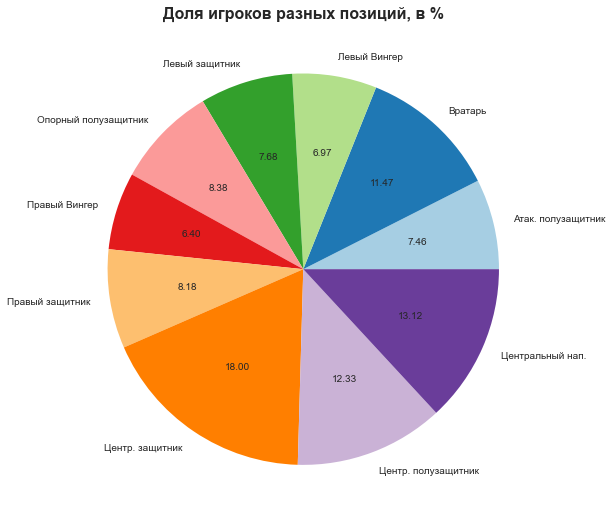

In [17]:
fig, ax = plt.subplots(figsize=(15, 9))

positions = df.groupby('Position').size()
positions[positions / sum(positions) * 100 > 5].plot(kind='pie', autopct='%.2f', colors=sns.color_palette("Paired"), ax=ax)
ax.set_ylabel('', visible=False)
ax.set_title('Доля игроков разных позиций, в %', fontdict={'size': 16, 'weight': 'bold'})


<h4>H3 отвергнута: </h4>
<li>Доля вратарей на трансферном рынке составляет 12.53 процента</li>

<h3>H4: распределение стоимости у игроков с разными категориями позиций совпадает</h3>

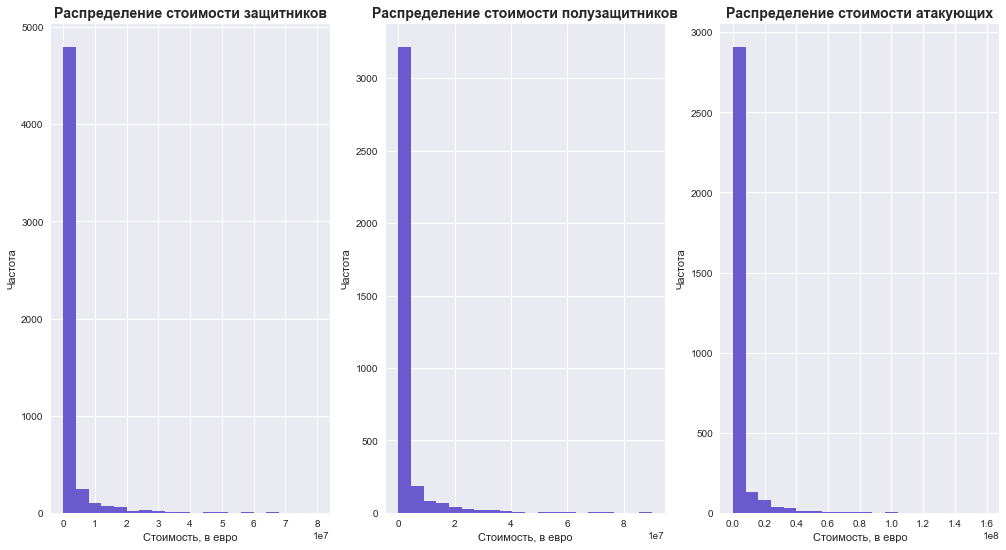

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(17, 9))
for i in range(3):
    ax[i].hist(df[df['Position_cat'] == df['Position_cat'].unique()[i]]['Cost'], bins=20, color='slateblue')
    ax[i].set_title(f'Распределение стоимости {["защитников", "полузащитников", "атакующих"][i]}', fontdict={'size': 14, 'weight': 'bold'})
    ax[i].set_xlabel('Стоимость, в евро')
    ax[i].set_ylabel('Частота')

<h4>H4 не отвергнута:</h4>
<li>Все три распределения практически идентичны</li>

<h3>H5: распределение стоимости в зависимости от возраста является нормальным</h3>

Text(0, 0.5, 'Стоимость, в евро')

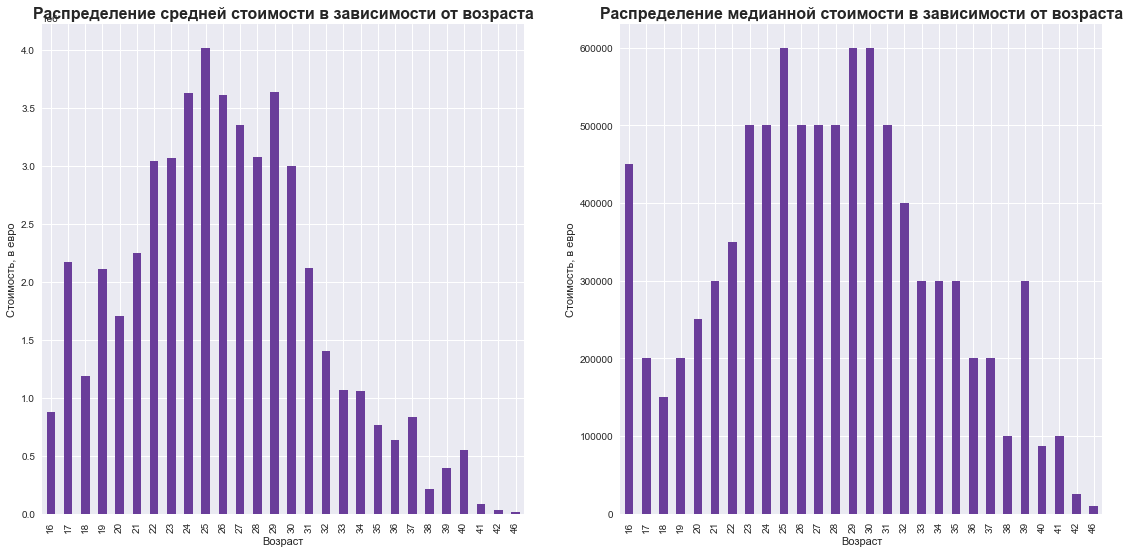

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(19, 9))

df.groupby('Age')['Cost'].mean().plot(kind='bar', ax=ax[0], color=sns.color_palette("Paired")[9])
ax[0].set_title('Распределение средней стоимости в зависимости от возраста', fontdict={'size': 16, 'weight': 'bold'})
ax[0].set_xlabel('Возраст')
ax[0].set_ylabel('Стоимость, в евро')


df.groupby('Age')['Cost'].median().plot(kind='bar', ax=ax[1],  color=sns.color_palette("Paired")[9])
ax[1].set_title('Распределение медианной стоимости в зависимости от возраста', fontdict={'size': 16, 'weight': 'bold'})
ax[1].set_xlabel('Возраст')
ax[1].set_ylabel('Стоимость, в евро')

<h4>H5 не отвергнута:</h4>
<li>Распределения как средней, так и медианной стоимости в зависимости от возраста игрока являются нормальными</li>
<li>Однако аномальными значениями являются стоимости 16-ти и 39-ти летних игроков вследствие их небольшого количества на трансферном рынке</li>

<h1>6. Постороение моделей</h1>
 
  

<h2>Множественная регрессия</h2>
<p>Задача: оценить факторы, влияющие на стоимость игроков</p>

In [20]:
import statsmodels.formula.api as smf
# построим модель множественной регресии, которая покажет значимость различных факторов
lm = smf.ols(formula="""Cost ~ Age + Height + Contract_duration_days + Contract_remaining_days + Right
             + Two_citizenships + Position_cat""", data=df).fit()
print(lm.params)
print(lm.summary())

Intercept                 -4.332463e+06
Age                        1.603219e+04
Height                     1.039243e+04
Contract_duration_days     1.683620e+03
Contract_remaining_days    3.653478e+03
Right                     -4.184899e+05
Two_citizenships           1.898134e+06
Position_cat               7.431242e+05
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   Cost   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     225.7
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          7.26e-317
Time:                        16:34:20   Log-Likelihood:            -2.1250e+05
No. Observations:               12312   AIC:                         4.250e+05
Df Residuals:                   12304   BIC:                         4.251e+05
Df Model:                        

In [41]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices('''Cost ~ Age + Height + Contract_duration_days + Contract_remaining_days +
                 Right + Two_citizenships + Position_cat', data=df, return_type='dataframe''')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,858.373749,Intercept
1,1.183884,Age
2,1.118446,Height
3,1.395937,Contract_duration_days
4,1.490077,Contract_remaining_days
5,1.020347,Right
6,1.006484,Two_citizenships
7,1.137050,Position_cat


<p>Как мы видим из таблицы выше, VIF у всех признаков около единицы, то есть между ними нет высокой мультиколлинеарности</p>

In [21]:
# Уберем незначимые факторы и построим модель еще раз
lm = smf.ols(formula="""Cost ~ Contract_duration_days + Contract_remaining_days
             + Right + Two_citizenships + Position_cat""", data=df).fit()
print(lm.params)
print(lm.summary())


Intercept                 -1.998344e+06
Contract_duration_days     1.704732e+03
Contract_remaining_days    3.589420e+03
Right                     -3.993907e+05
Two_citizenships           1.902478e+06
Position_cat               7.108026e+05
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   Cost   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     315.5
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          6.29e-319
Time:                        16:34:20   Log-Likelihood:            -2.1250e+05
No. Observations:               12312   AIC:                         4.250e+05
Df Residuals:                   12306   BIC:                         4.251e+05
Df Model:                           5                                         
Covariance Type:            nonrob

Классическая множественная регрессия методом обычных наименьших квадратов показывает низкое качество, поэтому попробуем проверить наши данные на модели дерева регрессионных решений

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

import numpy as np
np.random.seed(123)

# в переменную Х передадим числовые столбцы датафрейма, в переменную у - целевую переменную
X = df.drop(['Cost', 'Position', 'Start_contract_date', 'Expiration_contract_date', 'Nation',
             'Main_leg', 'Amount_of_citizenships', 'Name', 
             'Age', 'Height', 'Main_nation'], axis=1)
y = df['Cost']


In [23]:
# разобьем выборку на тестовую и тренировочную, передав 30 процентов выборки в тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# проведем масшатбирование числовых столбцов, чтоб избавиться от эффекта масштаба
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [24]:
# обучим нашу модель, передав в нее тренировочную выборку с глубиной рекурсивных вызовов, равной 3
regressor = DecisionTreeRegressor(max_depth=3)
regressor.fit(X_train, y_train)

# попробуем предсказать значения целевой переменной с помощью метода predict, 
# передав тестовую выборку в натренированную модель
y_pred = regressor.predict(X_test)


In [25]:
df2 = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df2['Predicted'] = df2['Predicted'].astype(int)
df2

# заметим, что предсказанные значения сильно отличаются от предсказанных. Следовательно, данная модель также плохо прогнозирует стоимость футболистов.

,Actual,Predicted
9847,300000,845966
15994,50000,845966
10538,450000,845966
7786,4000000,845966
13747,300000,1918727
...,...,...
7031,400000,2724898
4190,16000000,9297476
12507,150000,845966
2490,2000000,9297476


In [26]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3162130.086844158
Mean Squared Error: 67866027048122.51
Root Mean Squared Error: 8238083.942769854


<h4>Выводы: </h4>
<li>Модель множественной регресии является незначимой, так как R squared у нее < 0.5</li>
<li></li>
<li>Прогнозирование стоимости футболистов на основе таких показателей как рост, возраст, позиция и т.д. невозможно, так как среди дорогостоящих и менее дорогих футболистов встречаются игроки с одинаковыми физическими данными</li>

<h2>Логистическая регрессия</h2>
<p>Задача: построить алгоритм определения топовых игроков, то есть тех, чья стоимость превышает 15 млн. евро</p>

In [27]:
(df['Cost'] > 15_000_000).sum() # всего их 567

567

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
np.random.seed(123)

In [29]:
# определяющими факторами у нас будут количество дней до истечения контракта и возраст футболиста
df1 = df[df['Cost'] < 15_000_000][['Contract_remaining_days', 'Age', 'Cost']].sample(n=2000)
df2 = df[df['Cost'] >= 15_000_000][['Contract_remaining_days', 'Age', 'Cost']].sample(n=500)
sample = pd.concat([df1, df2])

X = sample[['Contract_remaining_days', 'Age']]
y = sample['Cost'].apply(lambda n: 1 if n >= 15_000_000 else -1)

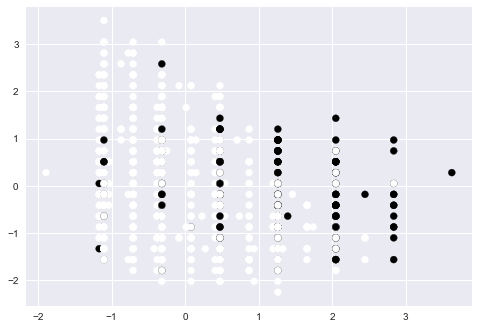

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train)

<h4>На основе данной диаграммы разброса можно утверждать, что данные линейно не разделимы, поэтому здесь необходима классификация</h4>

In [31]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.coef_)

[[1.06858788 0.20737577]]


In [32]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

-1    1403
 1     347
Name: Cost, dtype: int64
-1    597
 1    153
Name: Cost, dtype: int64


In [33]:
from sklearn.metrics import f1_score
print('Linear Regression: ', f1_score(y_test, lr.predict(X_test)))

Linear Regression:  0.3611111111111111


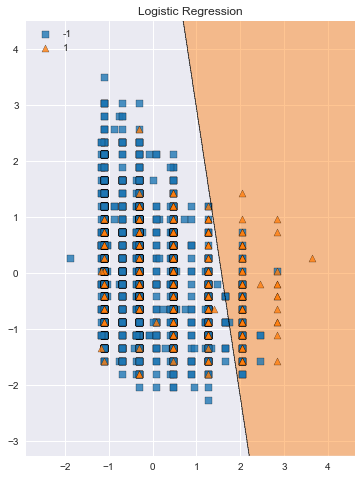

In [34]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(1, 2)

fig = plt.figure(figsize=(13, 8))

labels = ['Logistic Regression']
for clf, lab, grd in zip([lr],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X = X_train, y = np.array(y_train), clf=clf, legend=2)
    plt.title(lab)

plt.show()

In [35]:
(y_train == 1).sum() / len(y_train)

0.1982857142857143

In [36]:
from sklearn.metrics import roc_curve, auc


In [37]:
lr = LogisticRegression(C=0.5)
lr.fit(X_train, y_train)

LogisticRegression(C=0.5)

In [38]:
fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])

Text(0.5, 1.0, 'ROC кривая')

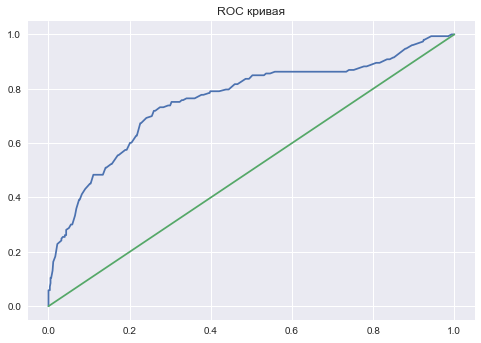

In [39]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title('ROC кривая')

In [40]:
auc(fpr, tpr)


0.7576882232513329

<h4>Выводы: </h4>
<li>Модель логистической регрессии с высокой точностью (0.74-0.76) определяет игроков, чья стоимость начинается от 15 млн. евро</li>
<!-- <li></li> -->